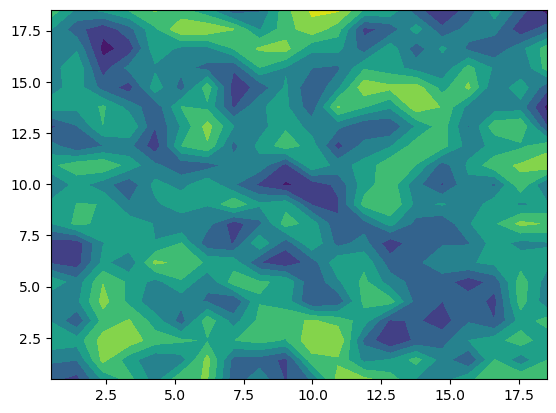

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import dolfinx
from dolfinx.mesh import locate_entities_boundary
from mpi4py import MPI
from dolfinx.mesh import create_box, CellType
from dolfinx.fem import functionspace, Function
from dolfinx.fem.petsc import LinearProblem
from ufl import dx, grad, inner, lhs, rhs,TrialFunction, TestFunction
from petsc4py import PETSc
import time
import matplotlib.animation as animation

# Define domain and mesh
domain = [[0, 0, 0], [19,19,3]]  # Physical dimensions
cells = [19, 19, 3]  # Mesh divisions
mesh = create_box(MPI.COMM_WORLD, domain, cells, cell_type=CellType.tetrahedron)

# Function space for pressure head h
V = functionspace(mesh, ('CG', 1))

# Define trial and test functions
h = TrialFunction(V)
v = TestFunction(V)

# Random initial condition for theta (water content)
theta_init = Function(V)
theta_init.interpolate(lambda x: np.random.uniform(0,1,size=x.shape[1]))

# Time step and parameters
dt = 0.1  # Time step size
total_time = dt*200 # Total simulation time
alpha = 0.1  # Absorption coefficient
K_val = 0.01  # Hydraulic conductivity (constant for simplicity)

# Define source term (random function changing over time)
# def random_source():
#     f = Function(V)
#     f.interpolate(lambda x: 0.1 * (np.random.rand(x.shape[1]) - 0.5))
#     return f

def random_source(V, mesh, top_surface_z):
    """
    Create a random source function applied only to the top surface.

    Parameters:
        V (FunctionSpace): The finite element function space.
        mesh (Mesh): The computational domain mesh.
        top_surface_z (float): The z-coordinate defining the top surface.

    Returns:
        Function: The source function with nonzero values only on the top surface.
    """
    f = Function(V)  # Create the function in the FE space

    # Identify the top surface (facets where z ≈ top_surface_z)
    top_facets = locate_entities_boundary(
        mesh, mesh.topology.dim - 1, lambda x: np.isclose(x[2], top_surface_z)
    )

    # Get the degrees of freedom (DoFs) on the top surface
    V_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, top_facets)

    # Generate a random source only on the top surface
    f.x.array[:] = 0  # Initialize with zero
    random_values = 0.1 * (np.random.rand(len(V_dofs)) - 0.5)
    f.x.array[V_dofs] = random_values  # Assign values only to top DoFs

    return f

# Weak form of Richards equation
top_surface_z = 3.0

# Initialize the random source term
S = random_source(V, mesh, top_surface_z)

#S = random_source()  # Initial source term
F = (h - theta_init) / dt * v * dx + K_val * inner(grad(h), grad(v)) * dx - S * v * dx + alpha * h * v * dx

# Solve the system
h_sol = Function(V)
problem = LinearProblem(lhs(F), rhs(F), u=h_sol)

# Visualization setup
fig, ax = plt.subplots()
frames = []  # Store frames for animation
Z_vec = []
Input = []

# Time stepping loop
for t in np.arange(0, total_time, dt):
    S = random_source(V, mesh, top_surface_z)  # Update source term
    Input.append(S.x.array.sum())  # Store input for later analysis
    problem.solve()
    theta_init.interpolate(h_sol)  # Update theta for next step
    
    # Extract top surface for visualization
    x = mesh.geometry.x
    top_mask = np.isclose(x[:, 2], 3)  # Identify top surface vertices
    top_values = h_sol.x.array[top_mask]
    
    # Reshape data for imshow (assuming structured x-y grid)
    grid_size = (cells[0] + 1, cells[1] + 1)
    Z = np.zeros(grid_size)
    X, Y = x[top_mask, 0], x[top_mask, 1]
    for i in range(len(X)):
        xi, yi = int(X[i]), int(Y[i])
        Z[xi, yi] = top_values[i]
    Z_vec.append(Z.reshape(grid_size[0]*grid_size[1]))
    # Store the frame
    frame = [ax.contourf(Z.T, origin='lower', extent=[0, 19, 0, 19], cmap='viridis')]
    frames.append(frame)

# Create and save the animation as a GIF
ani = animation.ArtistAnimation(fig, frames, interval=1, blit=True)
ani.save("richards_simulation.gif", writer=animation.PillowWriter(fps=10))

plt.show()


In [13]:
np.shape(Z_vec)

(200, 400)

In [14]:
Z_vec1 = np.array(Z_vec)
Z_vec1.T.shape
Input = np.array(Input)
Input.shape

np.savetxt("simulation_1.csv", Z_vec1.T, delimiter=",")
np.savetxt("InputData1.csv", Input, delimiter=",")
Z_vec1.shape


(200, 400)

In [20]:
Z_vec1.T[:100,0].reshape([10,10]).shape
Z_vec1[100:200,0].shape

(100,)